<a href="https://colab.research.google.com/github/Amal-Nasir/CNN_Colab/blob/main/CNN_LIDC_Mal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd ..

/


In [ ]:
cd content/drive/MyDrive/MedIx\ REU/Datasets

/content/drive/MyDrive/MedIx REU/Datasets


In [ ]:
from __future__ import absolute_import
from __future__ import print_function
import tensorflow as tf
import numpy as np  # linear alg
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import keras
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras import backend as K
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, silhouette_score, silhouette_samples, homogeneity_completeness_v_measure
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize, MinMaxScaler
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, SpectralClustering, AgglomerativeClustering
import os
from os import path
#from s_dbw import S_Dbw, SD

In [ ]:
##### Parameters #####
random.seed(25)
run = 100
metric_names = ['Silhouette Coefficients ', 'Average Silhouette Metric ', 'Scaled Multiplied Silhouette Metric ']
name9 = 'test case {}/{} Correlation.xlsx'.format(run, metric_names[0])
writer1 = pd.ExcelWriter(name9)
name10 = 'test case {}/{} Correlation.xlsx'.format(run, metric_names[1])
writer2 = pd.ExcelWriter(name10)
name11 = 'test case {}/{} Correlation.xlsx'.format(run, metric_names[2])
writer3 = pd.ExcelWriter(name11)
#writer_list = [writer1, writer2, writer3]                            # uncomment this out if we want to look at all of the metrics
writer_list = [writer1]                                               # comment this out if we want to look at all of the metrics
metric_names = ['Scaled Multiplied Silhouette Metric ']               # comment this out if we want to look at all of the metrics

In [ ]:
##### User defined functions #####
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

In [ ]:
def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [ ]:
def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
      uses y_true as Y and y_pred as the Euclidean distance between dissimilar points
    '''
    margin = 1
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

In [ ]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)

In [ ]:
def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))

In [ ]:
def cluster_centroid(embeddings, y_sc, numclusters):
    centroids = [] #center indice values
    for i in range(numclusters): #for each class...
        inds = np.where(y_sc==i)[0] #list of all images within the same proposed class
        inds_embed = embeddings[inds] #feature vectors of all these images
        inds_embed1 = np.array(inds_embed) #numpy array of this matrix
        column_mean = inds_embed1.mean(axis=0) #mean per dimension (x, y, z, etc.)
        centroids.append(column_mean) #append to the list
    return centroids

In [ ]:
def wss(centroids, embeddings, y_sc, numclusters, n): #in 2d - total wss (not average)
    wss_percluster = [] # list of total distance per class
    closest_inds = []
    farthest_inds = []
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0] #list of all images within the same proposed class
        inds_embed = embeddings[inds] #feature vectors of all these images
        inds_embed1 = np.array(inds_embed) #numpy array of this matrix
        after_subtraction = inds_embed1 - centroids[i] #subtracting the centroid indices from the image indices
        squared_matrix = np.square(after_subtraction) #square the distance values
        sum_rows = np.sum(squared_matrix, axis = 1) #add all fo the distances of the same image
        sum_cols = np.sum(sum_rows) #add all of image distances together of the same class
        wss_percluster.append(sum_cols) #include this in the total distances per class
        ## find the images farthest/closest to centroid
        indclosest = np.argpartition(sum_rows, n)[:n]
        indfarthest = np.argpartition(sum_rows, -n)[-n:]
        indclosestnum = inds[indclosest]
        indfarthestnum = inds[indfarthest]
        closest_inds.append(indclosestnum)
        farthest_inds.append(indfarthestnum) #final image number
    tot_wss = np.sum(wss_percluster) #sum all of the distances from all of the clusters into 1 value
    return tot_wss, closest_inds, farthest_inds

In [ ]:
# Silhouette plot
def silhouette_plt(y_sc, silhouette_vals, run, numclusters, indicator):
    cluster_labels = np.unique(y_sc)
    ax_lower, ax_upper = 0, 0
    cticks = []
    sil_plot = plt.figure()
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_sc == k]
        c_silhouette_vals.sort()
        ax_upper += len(c_silhouette_vals)
        color = plt.jet()
        plt.barh(range(ax_lower, ax_upper), c_silhouette_vals, height=1.0,
                         edgecolor='none', color=colors[i])
        cticks.append((ax_lower + ax_upper) / 2)
        ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--")
    plt.yticks(cticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    if indicator == 0:
        str2 = 'Unscaled Silhouette Plot For {} Clusters'.format(numclusters)
        name = 'test case {}/{} cluster/og silhouette plot'.format(run, numclusters)
    else:
        str2 = 'Min-Max Silhouette Plot For {} Clusters'.format(numclusters)
        name = 'test case {}/{} cluster/minmax silhouette plot'.format(run, numclusters)
    plt.title(str2)
    plt.tight_layout()
    # plt.show()
    # sil_plot.savefig(name)
    return silhouette_avg

In [ ]:
# Find the average silhouette number per cluster
def silhouette_cluster_average(y_sc, silhouette_values, numclusters):
    silhouette_clusters = []
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0]
        avg_ind = sum(silhouette_values[inds])/len(inds)
        silhouette_clusters.append(avg_ind)
    return silhouette_clusters

In [ ]:
# Make the silhouette cluster an array corresponding to the image numbers
def silhouette_cluster_array(y_sc, silhouette_clusters):
    silhouette_cluster_arr = []
    for im in range(len(y_sc)):
        cat = y_sc[im]
        c = silhouette_clusters[cat]
        silhouette_cluster_arr.append(c)
    silhouette_cluster_arr = np.array(silhouette_cluster_arr)
    return silhouette_cluster_arr

In [ ]:
# Save histograms for the metrics
def save_hist(data, filename, run, numclusters):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(data, color="black")
    ax.set_title(filename + 'Histogram')
    ax.set_xlabel(filename + 'Values')
    ax.set_ylabel('Frequency')
    #ax.set_xticks(minor=False)
    fig.tight_layout()
    #fig.savefig("test case {}/{} cluster/Histogram - {}.png".format(run, numclusters, filename), format='png')
    plt.show(fig)

In [ ]:
# Comparison of highest uncertainty and radiologist disagreement points - do this with instance ID, not index number!!
# radio_classes = [3 - All Agree , 2 - High Agreement, 1 - Low Agreement, 0 - No Agreement]
def radio_comparison(agreement_id, total_ids, metric, amount, radio_class):
  accuracies = []
  for r in amount:
    indslargest_metric = np.argpartition(metric, -r)[-r:]
    metric_id = total_ids[indslargest_metric]
    rad_ids = agreement_id[radio_class]
    intersection = np.intersect1d(rad_ids, metric_id)
    accuracy = len(intersection)  #number of overlap points
    accuracies.append(accuracy)
  return accuracies

In [ ]:
# Comparison of highest uncertainty and radiologist disagreement points - divided by number of images in each category
def radio_comparison2(agreement_id, total_ids, metric, amount, radio_class):
  accuracies = []
  for r in amount:
    indslargest_metric = np.argpartition(metric, -r)[-r:]
    metric_id = total_ids[indslargest_metric]
    rad_ids = agreement_id[radio_class]
    intersection = np.intersect1d(rad_ids, metric_id)
    accuracy = ((len(intersection))/(len(rad_ids)))  #number of overlap points / total number of metric points
    accuracies.append(accuracy)
  return accuracies

In [ ]:
##### Import Trained Model #####
model = keras.models.load_model("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Malignancy/CNN_machine_model" , compile = True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 69, 69, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 34, 34, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 12544)             0

In [ ]:
feature_extractor = keras.Model(
    inputs=model.inputs,
    outputs=model.get_layer(name="flatten").output)

In [ ]:
# pre set parameters
colors = ['#1f77b4', '#ff7f0e', '#a52a2a','#2ca02c',
          '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
          '#bcbd22', '#17becf', '#2cb49b', '#1ae700', '#711d7a', '#ff4d82','#2700ea']
radio_colors_mnist = ['#2a72a5','#ffb732','#6db6ac', '#6ba10c']
#radio_colors = ['#9e2020', '#d9920f', '#6d9fb6', '#568208'] #lighter colors...
radio_colors = ['#e81005', '#f7c00a', '#364acf', '#568208']
#['#048a94','#b81c07', '#100494','#cfd1d1']


In [ ]:
def getNormed(this_array, this_min = 0, this_max = 255, set_to_int = True):
    new_var = this_array.copy()
    rat = (this_max - this_min)/(new_var.max() - new_var.min())
    new_var = new_var * rat
    new_var -= new_var.min()
    new_var += this_min
    if set_to_int:
        return new_var.astype('uint8')
    return new_var

In [ ]:
#total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Malignancy/Agreement_Binary_Rating.csv")
total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Malignancy/machine_mal_ratings.csv")
total_nod = total['noduleID']
total_nod = np.array(total_nod)

image_folder = '/content/drive/MyDrive/MedIx REU/Datasets/Amal/images_1332'
train_images = []
train_noduleId = []
print(image_folder)

for dir1 in os.listdir(image_folder):
    print(dir1)
    if not dir1.startswith('.'):
        for file in os.listdir(os.path.join(image_folder, dir1)):
            #print(file)
            noduleID = file.split('.')[0]
            if not file.startswith('.'):
                noduleID = int(noduleID)
                train_noduleId.append(noduleID)
                temp_image = np.loadtxt(os.path.join(image_folder, dir1,file))
                temp_image = getNormed(temp_image)
                train_images.append(temp_image)

/content/drive/MyDrive/MedIx REU/Datasets/Amal/images_1332
Malignancy_5
Malignancy_1
Malignancy_4
Malignancy_2
Malignancy_3


In [ ]:
tr_df = pd.DataFrame(train_noduleId,columns =['noduleID'])
print(tr_df)

      noduleID
0          324
1         1888
2         1606
3         1427
4         1760
...        ...
1327      2301
1328      2583
1329      1772
1330       231
1331      2540

[1332 rows x 1 columns]


In [ ]:
train_slices = pd.merge(tr_df, total)
display(train_slices)

,noduleID,InstanceID,Agglomeration,Binary Rating,m1,m2,m3,m4,machine_Agreement,Agreement
0,324,4732,NaN,3,5.0,4.0,5.0,4.0,Low Radiologists Agreement,1
1,1888,28743,NaN,3,3.0,5.0,5.0,2.0,Low Radiologists Agreement,1
2,1606,24119,NaN,3,3.0,3.0,5.0,2.0,Low Radiologists Agreement,1
3,1427,21366,NaN,3,4.0,5.0,3.0,3.0,Low Radiologists Agreement,1
4,1760,26447,NaN,3,5.0,5.0,3.0,3.0,Low Radiologists Agreement,1
...,...,...,...,...,...,...,...,...,...,...
1327,2301,35200,NaN,3,3.0,4.0,1.0,3.0,Low Radiologists Agreement,1
1328,2583,39596,NaN,3,4.0,3.0,3.0,NaN,Low Radiologists Agreement,1
1329,1772,26626,3.0,2,4.0,3.0,3.0,3.0,High Radiologists Agreement,2
1330,231,3308,3.0,2,5.0,3.0,3.0,3.0,High Radiologists Agreement,2


In [ ]:
train_ids = train_slices["Binary Rating"]

In [ ]:
###### Retrieve the embeddings, run KNN analysis, and print tsne for TRAINING AND VALIDATION DATA COMBINED #####
# First, need to extract only training and validation indices from all data
##### Run all data (testing, training, and validation) to retrieve embeddings and plot tsne #####                               USE THIS ONE! :)
# read in file with all of the data

#total = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Malignancy/1332_images_71X71.csv")
#total_ids = total['InstanceID']
#total_images = total.drop(['InstanceID','Binary_Rating_Mal'], axis=1)
#print(total_images.head(5))

total_data = np.array(train_images).reshape(-1,71,71,1)


# get the embeddings
#total_embeddings_before = model.predict(total_data)
total_embeddings_before = feature_extractor.predict(total_data)
#total_embeddings2 = (total_embeddings_before[0] - total_embeddings_before[0].min()) / (total_embeddings_before[0].max() - total_embeddings_before[0].min())
total_embeddings2 = (total_embeddings_before - total_embeddings_before.min()) / (total_embeddings_before.max() - total_embeddings_before.min())
tot_embedded2 = TSNE(n_components=2,random_state=2).fit_transform(total_embeddings2)

42/42 [==============================] - 0s 4ms/step


<ipython-input-126-1a20bb2956d9>:21: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('#048a94')
<ipython-input-126-1a20bb2956d9>:22: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[1].set_color('#e81005')
<ipython-input-126-1a20bb2956d9>:23: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[2].set_color('#100494')
<ipython-input-126-1a20bb2956d9>:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[3].set_color('#cfd1d1')


(array([-30., -20., -10.,   0.,  10.,  20.,  30.,  40.]),
 [Text(0, -30.0, '−30'),
  Text(0, -20.0, '−20'),
  Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40')])

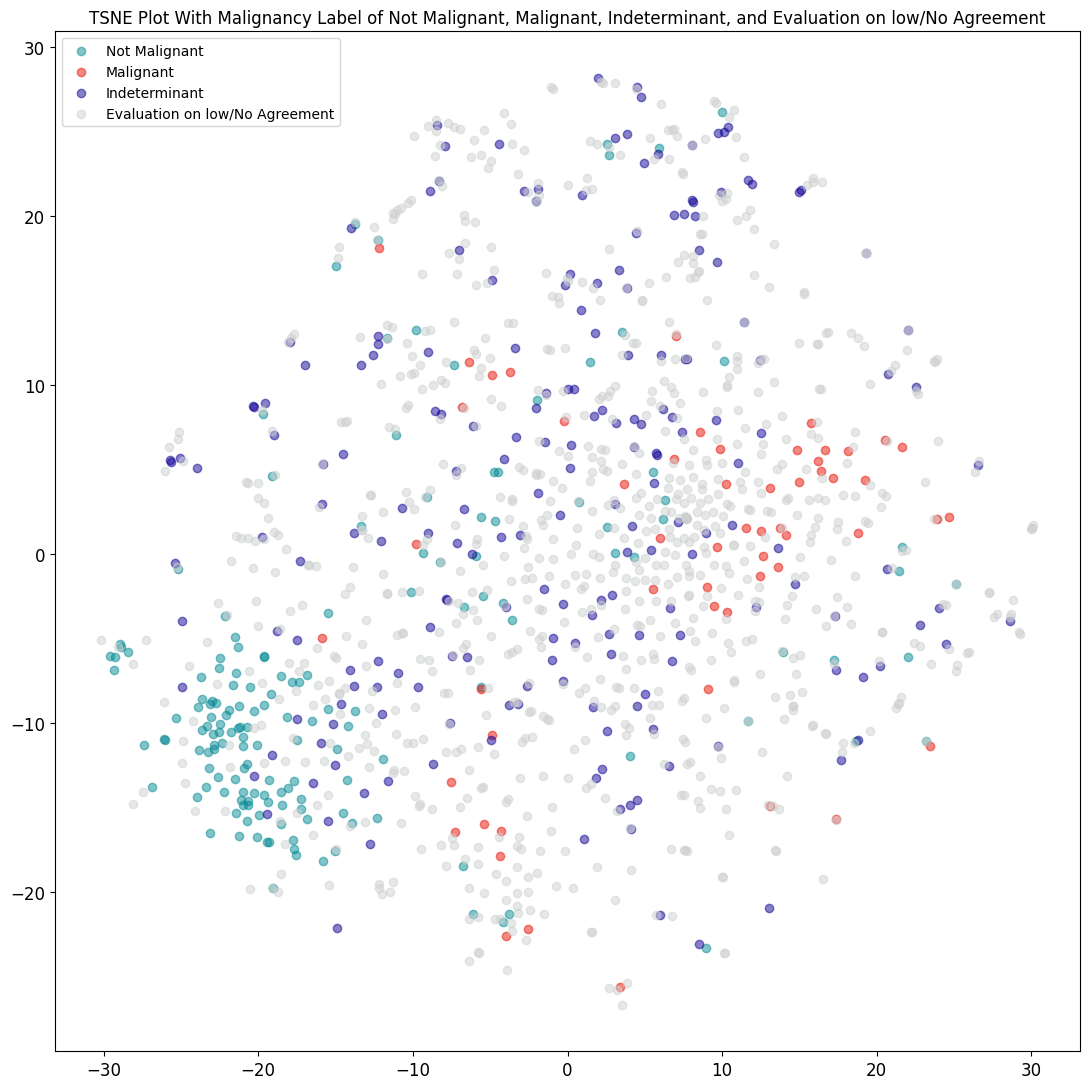

In [ ]:
## Print tsne with class labels (spic/non-spic) for training and validation data
#Binary_Rating = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Malignancy/Agreement_Binary_Rating.csv")
total_ids = train_slices['InstanceID'] #pandas dataframe
radio_ids2 = total_ids.values #list
Bin_Rating = train_slices['Binary Rating']

spic_tsne = plt.figure(figsize=(11,11))
spic_colors = ['#048a94','#e81005', '#100494','#cfd1d1'] # RED, BLUE   # 1 = Spiculated, 0 = Not Spiculated
radio_classes = [0, 1, 2, 3]
radio_names = spic_legend = ['Not Malignant', 'Malignant','Indeterminant', 'Evaluation on low/No Agreement']

for i in radio_classes:
    inds = np.where(Bin_Rating==i)
    plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=spic_colors[i])

plt.title('TSNE Plot With Malignancy Label of Not Malignant, Malignant, Indeterminant, and Evaluation on low/No Agreement')                                                         # commented out title
plt.legend(spic_legend, fontsize=10, loc=2)
ax = plt.gca()
leg = ax.get_legend()

leg.legendHandles[0].set_color('#048a94')
leg.legendHandles[1].set_color('#e81005')
leg.legendHandles[2].set_color('#100494')
leg.legendHandles[3].set_color('#cfd1d1')

#plt.legend(handles=scatter.legend_elements()[0], labels=spic_legend, fontsize=17, loc=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#spic_tsne.savefig(name9, bbox_inches='tight')

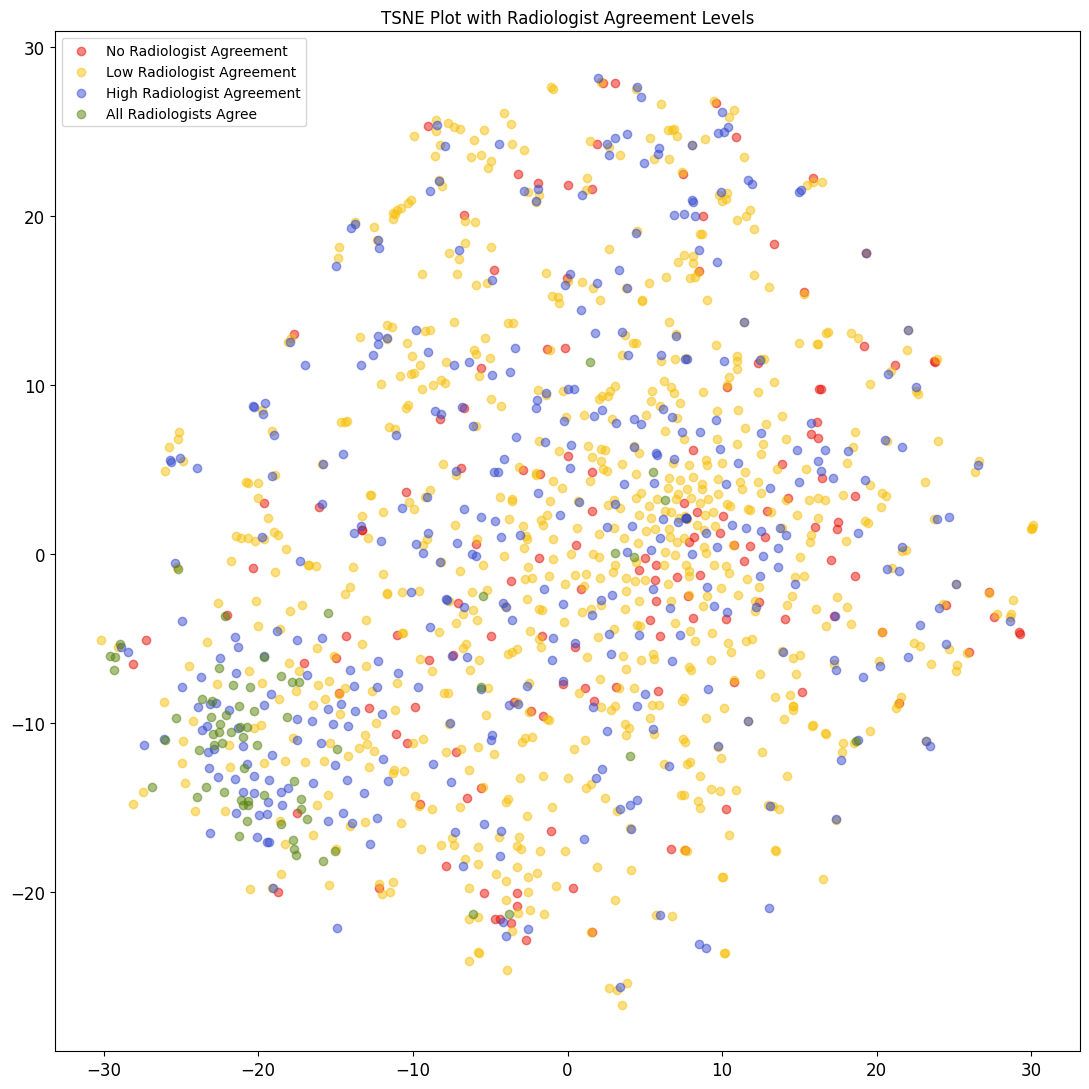

In [ ]:
## plotting the tsne with varying levels of radiologist disagreement
#radiologist = pd.read_csv("/content/drive/MyDrive/MedIx REU/LIDC Agreement Files/Everything_Agreements - integers.csv")
#radiologist = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Malignancy/Agreement_Binary_Rating.csv")
#radio_ids = radiologist['InstanceID'] #pandas dataframe
#radio_ids2 = radio_ids.values #list
agreements = train_slices['Agreement']
tsne_radio = plt.figure(figsize=(11,11))
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']

agreement_inds = []
agreement_id = []

for i in radio_classes:
  inds = np.where(agreements==i)
  plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=radio_colors[i])
  ids = radio_ids2[inds]
  agreement_inds.append(inds)  # should be in the order of high agreement -> low agreement  # also, these are the index numbers
  agreement_id.append(ids)  # these are the instance id's
plt.title('TSNE Plot with Radiologist Agreement Levels')                                                                       # commented out title
#plt.title('(b)', fontweight="bold", fontsize=20, y=-0.1)
plt.legend(radio_names, fontsize=10, loc=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
name5 = 'test case {}/tsne/radiologist tsne'.format(run)
#tsne_radio.savefig(name5, bbox_inches='tight')

In [ ]:
silhouette_total = []
wss_total = []
embeddings = total_embeddings2 #change depending on if we wanna run test cases vs all cases
X_embedded = tot_embedded2 #change depending on if we wanna run test cases vs all cases


{0: 1320, 1: 9, 2: 3}


Text(0.5, 1.0, 'Spectral Clustering TSNE With 3 Clusters')

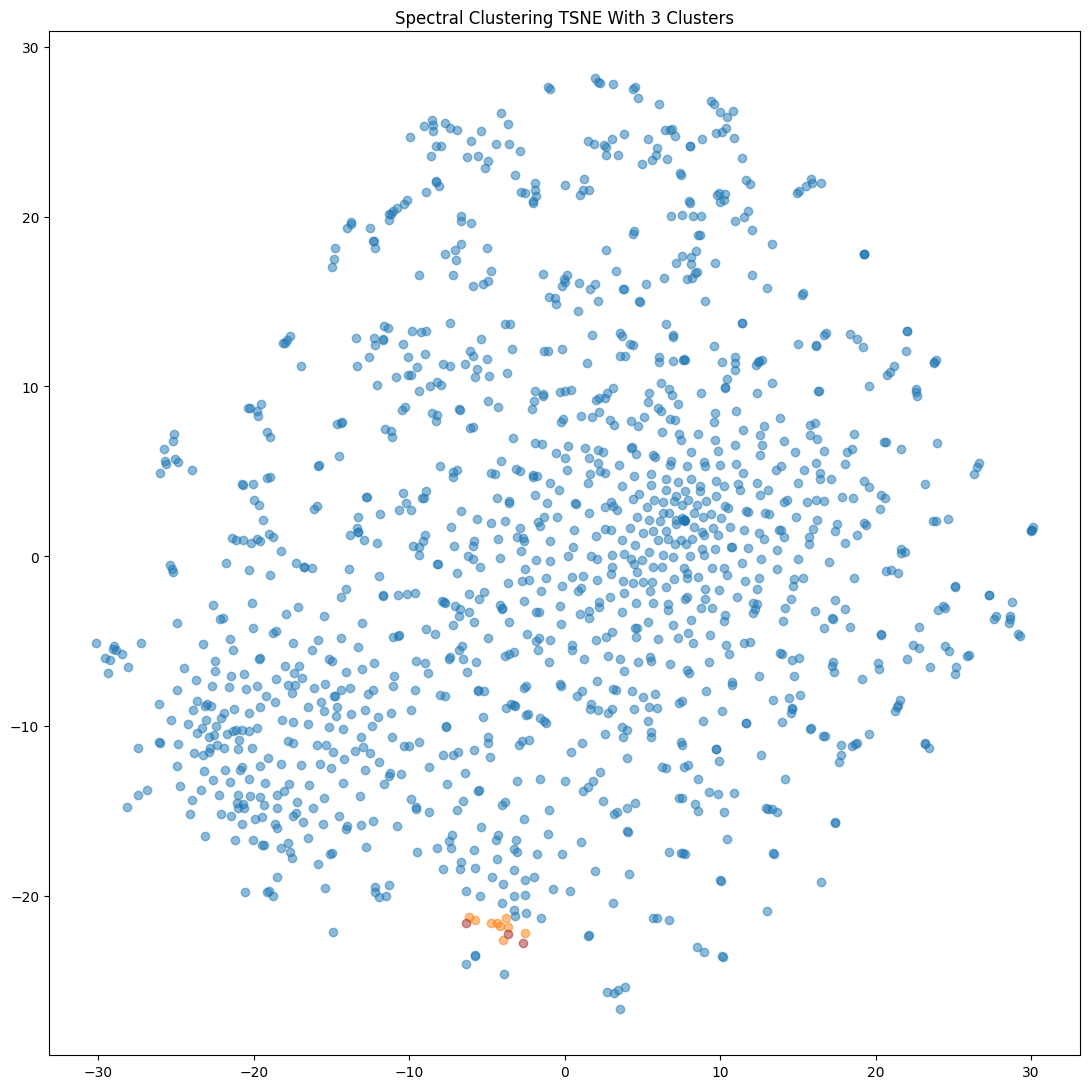

In [ ]:
##### Run spectral clustering on the embeddings for ALL of the data #####
numbers = [3] #[2, 3, 4, 5, 6] #number of clusters
silhouette_total = []
wss_total = []

embeddings = total_embeddings2 #change depending on if we wanna run test cases vs all cases
X_embedded = tot_embedded2 #change depending on if we wanna run test cases vs all cases
sc = SpectralClustering(n_clusters=numbers[0], random_state=0)
#sc = KMeans(n_clusters=numbers[0], random_state=0)
y_sc = sc.fit_predict(embeddings)
#Conunt how many instances in each cluster
unique, counts = np.unique(y_sc, return_counts=True)
print(dict(zip(unique, counts)))
# plot the tsne with spectral clusters
og_spectral = plt.figure(figsize=(11,11))
for i in range(0,numbers[0]):
    inds = np.where(y_sc==i)[0]
    #print(inds)
    plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])
name3 = 'test case {}/{} cluster/spectral tsne'.format(run, numbers[0])
plt.title('Spectral Clustering TSNE With {} Clusters'.format(numbers[0]))

In [ ]:
##### Data Analysis: WSS & Silhouette #####
# Calculate centroids and WSS
centroids = cluster_centroid(embeddings, y_sc, numbers[0])
wss_clusterlist, closest_ind_number, largest_ind_number = wss(centroids, embeddings, y_sc, numbers[0], 0) # only want the 0 highest and lowest points -- because the clusters are so small this is necessary for now
silhouette = silhouette_score(embeddings, y_sc, metric = 'euclidean', random_state=9)
wss_total.append(wss_clusterlist) # for the wss elbow plot
silhouette_total.append(silhouette)

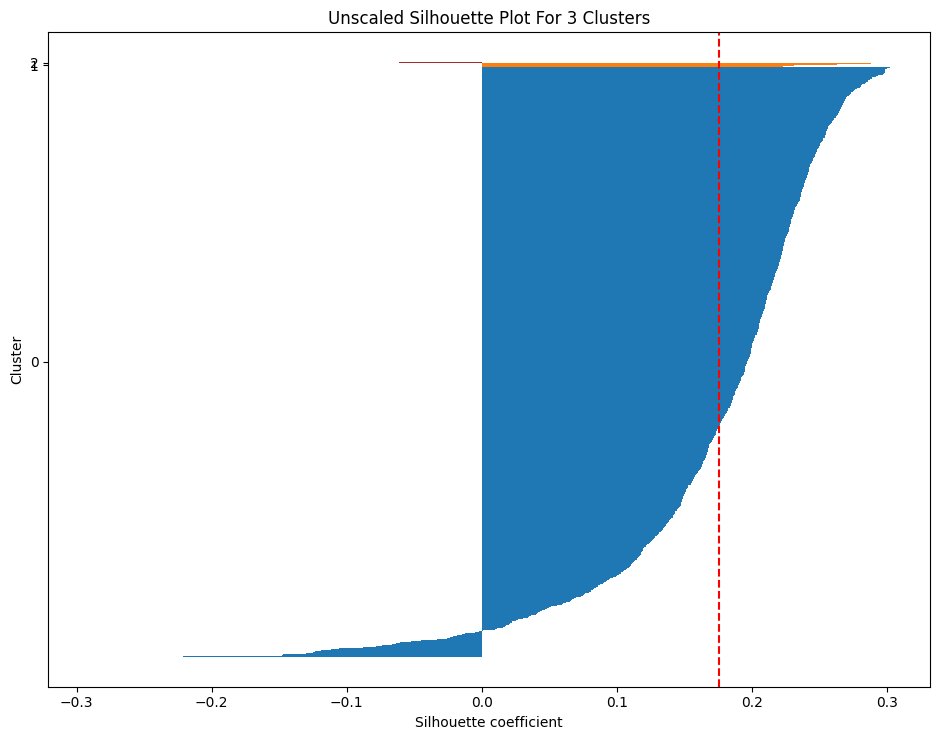

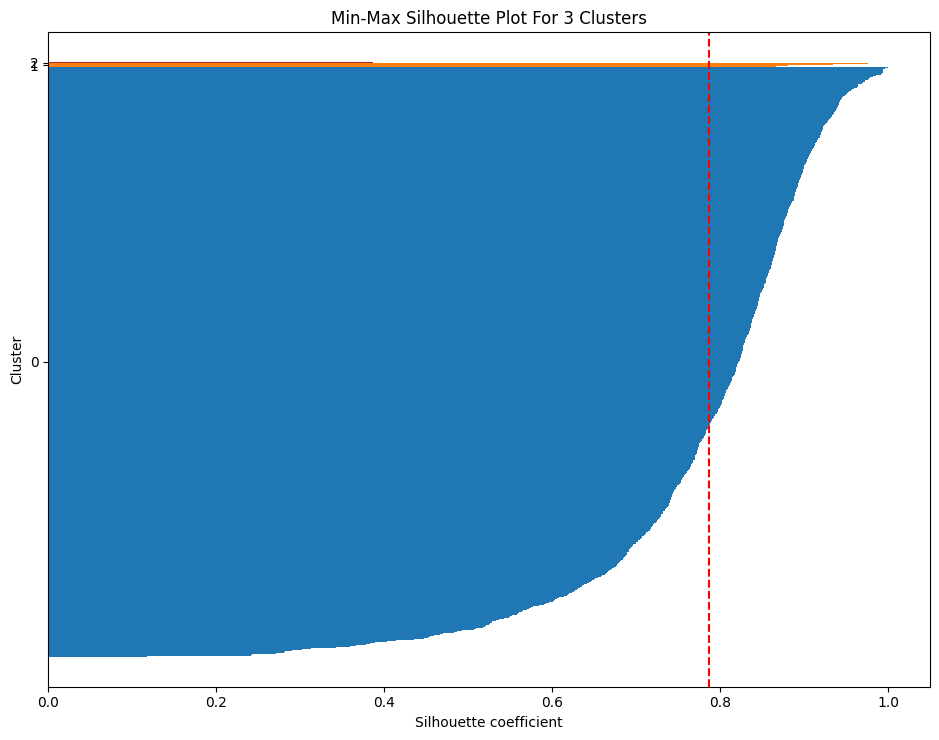

In [ ]:
# First, do all silhouette work on the raw embeddings
silhouette_valsb4 = silhouette_samples(embeddings, y_sc, metric='euclidean') # get the silhouette value per sample
silhouette_avgb4 = silhouette_plt(y_sc, silhouette_valsb4, run, numbers[0], 0) # create and save the silhouette plot, and find the average of all of the silhouette scores
silhouette_clustersb4 = silhouette_cluster_average(y_sc, silhouette_valsb4, numbers[0])
sil_clusterb4_avg = np.mean(silhouette_clustersb4) # average all of the averaged silhouette cluster scores
stdclustersb4 = np.std(silhouette_clustersb4) # find the standard deviation of the averaged silhouette cluster scores
sil_clus_arrayb4 = silhouette_cluster_array(y_sc, silhouette_clustersb4) # make the silhouette cluster an array corresponding to the image numbers
# Min Max all of the silhouette values, then repeat
scaler = MinMaxScaler()
silhouette_vals = scaler.fit_transform(silhouette_valsb4.reshape(-1,1))
silhouette_vals = silhouette_vals.flatten()
sil_avg_minmax = silhouette_plt(y_sc, silhouette_vals, run, numbers[0], 1)
silhouette_clusters = silhouette_cluster_average(y_sc, silhouette_vals, numbers[0])
sil_cluster_avg = np.mean(silhouette_clusters)
stdclusters = np.std(silhouette_clusters)
sil_clus_array = silhouette_cluster_array(y_sc, silhouette_clusters)


In [ ]:
# Apply the reverse metric to the silhouette coefficients
rev_silhouette_vals = silhouette_vals
actual_silhouette_vals = 1 - silhouette_vals

# Take the average of the scaled silhouette values
scaler = MinMaxScaler()
ci_avg = 1 - np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ##  < to switch the metric backwards
ci_avg2 = np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ## < for original metric (comparable to KNN)

# Multiply the scaled silhouette values
ci = 1 - (np.multiply(silhouette_vals, sil_clus_array))  ##  < to switch the metric backwards
ci_norm = scaler.fit_transform(ci.reshape(-1,1)) #< min max the confidence interval values
ci_norm = ci_norm.reshape(len(y_sc))
ci2 = np.multiply(silhouette_vals, sil_clus_array)  ##  < for original metric (comparable to KNN)
ci2_norm = scaler.fit_transform(ci2.reshape(-1,1)) #< min max the confidence interval values
ci2_norm = ci2_norm.reshape(len(y_sc))


In [ ]:
# Output to a file
dictionary = {'Image Number': total_ids, 'Sil Vals Scaled': actual_silhouette_vals, 'Rev Sil Vals Scaled': rev_silhouette_vals,
              'Avg Sil Metric': ci_avg, 'Rev Avg Sil Metric': ci_avg2,
              'Multiplied Sil Metric Scaled': ci_norm, 'Rev Multiplied Sil Metric Scaled': ci2_norm,
              'Sil Cluster Value Scaled': sil_clus_array, 'Clustered Class': y_sc}
data = pd.DataFrame(dictionary)
filename2 = 'test case {}/{} cluster/output file.xlsx'.format(run, numbers[0])

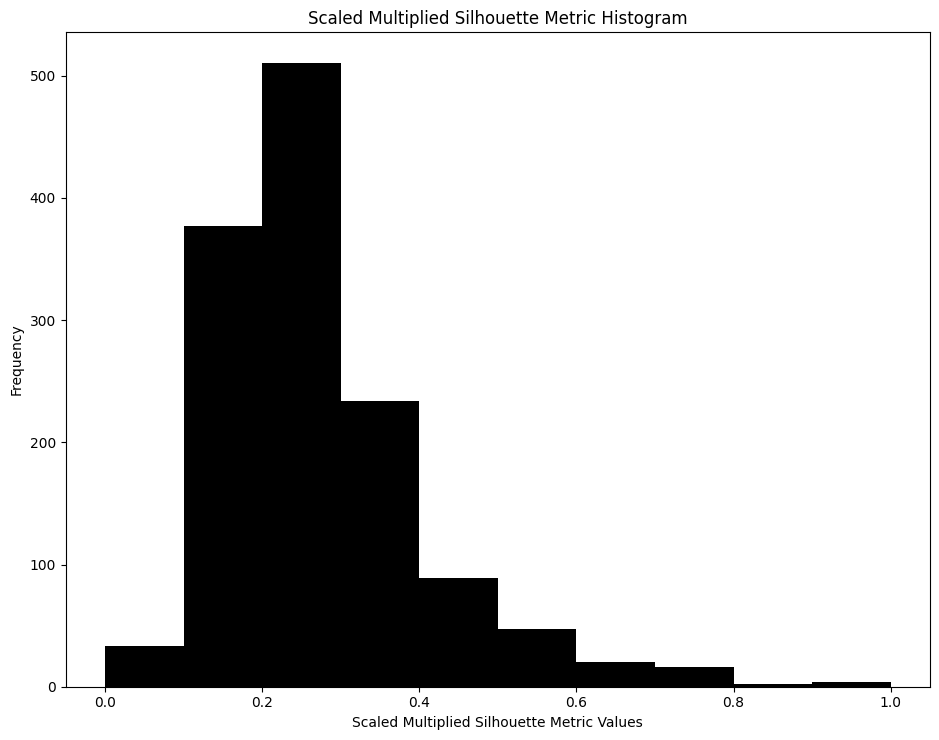

In [ ]:
## Plot histograms for the metrics
list_of_metrics = [ci_norm]
#list_of_metrics = [actual_silhouette_vals, ci_avg, ci_norm]
for q in range(len(list_of_metrics)):
    save_hist(list_of_metrics[q], metric_names[q], run, numbers[0])

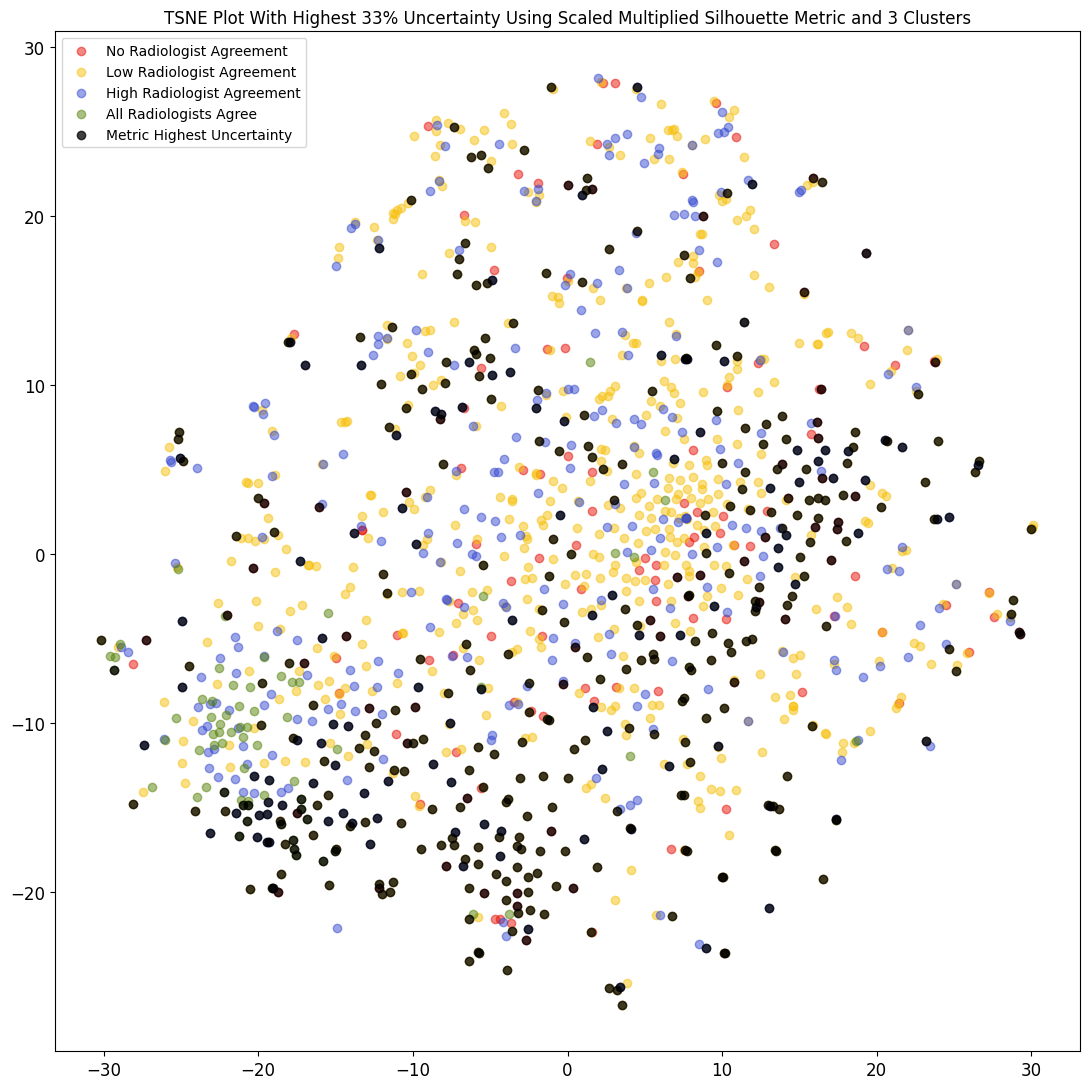

In [ ]:
for m in range(len(list_of_metrics)):
    newlegend = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree', 'Metric Highest Uncertainty']
    newlistnum = [441] #33% #[353, 706] #25%, 50%

    for r in newlistnum:
      indlargest = np.argpartition(list_of_metrics[m], -r)[-r:]
      new1 = plt.figure(figsize=(11,11))
      for i in radio_classes:
        inds = np.where(agreements==i)
        plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=radio_colors[i])
      for k in indlargest:
        plt.scatter(X_embedded[k,0], X_embedded[k,1], alpha=0.75, color = 'black')
      title2 = 'TSNE Plot With Highest {}% Uncertainty Using {}and {} Clusters'.format(str(round(r/(len(y_sc))*100)), metric_names[m], numbers[0])
      plt.title(title2)                                                                                                                              # commented out title
      #plt.title('(c)', fontweight="bold", fontsize=20, y=-0.1)
      plt.xticks(fontsize=12)
      plt.yticks(fontsize=12)
      plt.legend(newlegend, fontsize=10, loc=2)
      plt.show()
      name8 = 'test case {}/{} cluster/RADIO - {}% highest uncertainty - {} clusters - {}'.format(run, numbers[0], str(round(r/(len(y_sc))*100)), numbers[0], metric_names[m])
      #new1.savefig(name8, bbox_inches='tight')

In [ ]:
list_of_metrics

[array([0.73931828, 0.12354595, 0.42045309, ..., 0.25737785, 0.37603411,
        0.13868501])]

In [ ]:
len(list_of_metrics)

1

In [ ]:
newlistnum

[441]

In [ ]:
###### Area evaluation #####
# lost this code, since we aren't going to use it in the paper, im not going to rewrite the whole thing...
area_data = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/LIDC_20130817_AllFeatures2D_AllSlices.csv")
area_ints = area_data['Area'].tolist()
area_ids = area_data['InstanceID'].tolist()
print(len(area_data))

39548


In [ ]:
##### Spiculation rate from all the training data (training and validation) #####
#total_Spic = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Malignancy/Agreement_Binary_Rating.csv")
total_Spic = pd.read_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Malignancy/machine_mal_ratings.csv")
print(len(total_Spic))
spic_ids = total_Spic['InstanceID'].tolist()
spic_tr_val = total_Spic['Binary Rating'].tolist()
vis_tr_te = total_Spic['Agreement'].tolist()

1332


In [ ]:
##### Highest Uncertainty Points #####

## obtain highest uncertainty indices
unc_index = np.argpartition(ci_norm, -1332)[-1332:] #3742
unc_values = ci_norm[unc_index]
unc_ids = total_ids[unc_index]
unc_imgs = total_data[unc_index]

## determine radiologist agreement per image
# already defined variables:
  # radio_classes = [0, 1, 2, 3]
  # radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']
  # agreement_id - these are the instance id's

# fix the agreement id variable to be iterable...
agreement_id2 = []
agreement_levels = []
counter = 0
for a in agreement_id:
  for k in a:
    agreement_id2.append(k)
    agreement_levels.append(counter)
  counter += 1

# retrieve vals for specific ids (highest uncertainty ids)
uncertainty_agreement = []
uncertainty_names = []

for k in unc_ids:
  agr_index = agreement_id2.index(k)
  unc_agr = agreement_levels[agr_index]
  unc_agr2= radio_names[unc_agr]

  uncertainty_agreement.append(unc_agr)
  uncertainty_names.append(unc_agr2)

## get the areas for each image
unc_areas = []
for j in unc_ids:
  if j in area_ids:
    area_index = area_ids.index(j)
    act_area = area_ints[area_index]
    unc_areas.append(act_area)

######### ---Amal--- #########
## get train and test label for each image
all_vis = []
for j in unc_ids:
  if j in spic_ids:
    tr_te_index = spic_ids.index(j)
    act_tr_te = vis_tr_te[tr_te_index]
    all_vis.append(act_tr_te)

## get spiculation rating for each image
spic_rate = []
instance_id = []
for j in unc_ids:
  if j in spic_ids:
    spic_index = spic_ids.index(j)
    spic_r = spic_tr_val[spic_index]
    spic_rate.append(spic_r)
    instance_id.append(j)

######### ---Amal--- #########


## print out each image
counter = 0

#To get uncertinaty scores for distrbution
num = []
agre = []
siz = []
tr_te = []
spic = []
cat_t = []
inst_id = []

for l in range(len(unc_imgs)):
  new_l = unc_imgs[l].reshape(71,71)
  actual_unc = unc_values[l]
  num.append(actual_unc)
  unc_name = uncertainty_names[l]
  agre.append(unc_name)
  area_act = unc_areas[l]
  siz.append(area_act)
  ######### ---Amal--- #########
  #cat_unc = cat[l]
  #cat_t.append(cat_unc)
  tr_te_unc = all_vis[l]
  tr_te.append(tr_te_unc)
  spic_unc = spic_rate[l]
  spic.append(spic_unc)
  id_inst = instance_id[l]
  inst_id.append(id_inst)

  '''unc_fig = plt.figure()
  plt.imshow(new_l,cmap='gray')
  plt.xticks([])
  plt.yticks([])
  unc_title = 'Uncertainty Score: {}\n{}\nSize: {}'.format(round(actual_unc, 4), unc_name, area_act)
  plt.title(unc_title, y=-0.25)
  name16 = 'test case {}/highest uncertainty/{}'.format(run, counter)
  #unc_fig.savefig(name16, bbox_inches='tight')
  counter += 1 '''

In [ ]:
print(len(unc_ids))

1332


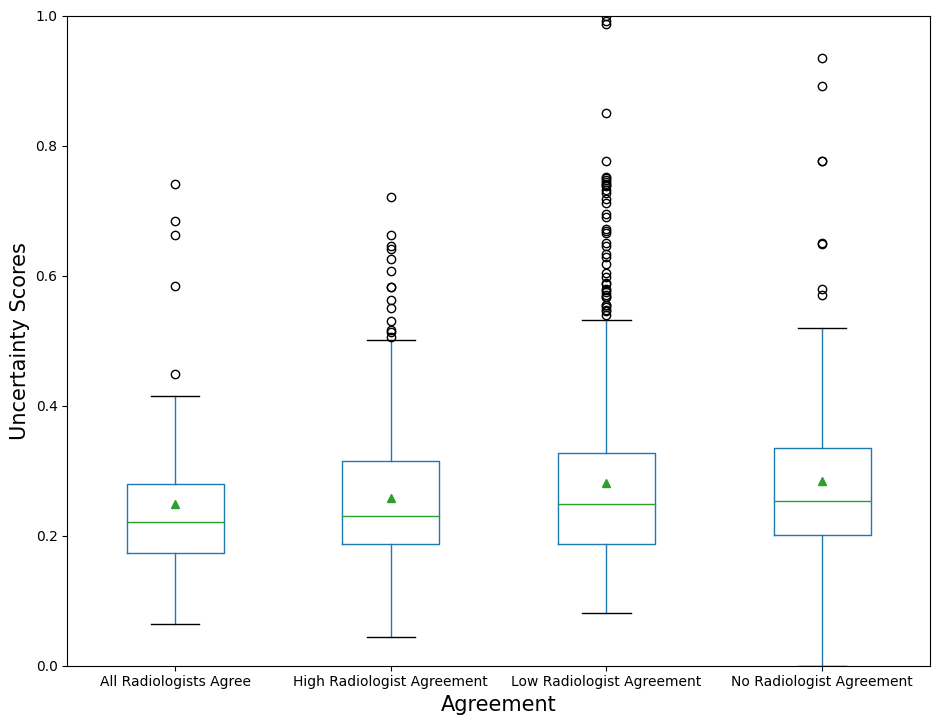

In [ ]:
data = {'InstanceID': inst_id,
        'Score': num,
        'Agreement': agre,
        'Spiculation':spic,
        'Size': siz}
        #'Category': cat_t}

# Convert the dictionary into DataFrame
df = pd.DataFrame(data)
#df.to_csv("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/malignancy/max_scores.csv")
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Agreement',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Agreement", fontdict={'fontsize':15})
plt.show()

In [ ]:
np.savetxt("/content/drive/MyDrive/MedIx REU/Datasets/Amal/CNN/Malignancy/Spectral_machine_CNN_Mal_scores.csv", df, fmt= "%s", delimiter=',')

In [ ]:
m2 = df.groupby(['Agreement'])['Score'].mean().values
print(m2)

[0.24813732 0.25783938 0.2803649  0.28458336]


In [ ]:
m1 = df.groupby(['Agreement'])['Score'].median().values
print(m1)

[0.22123185 0.23049896 0.2490682  0.25313907]


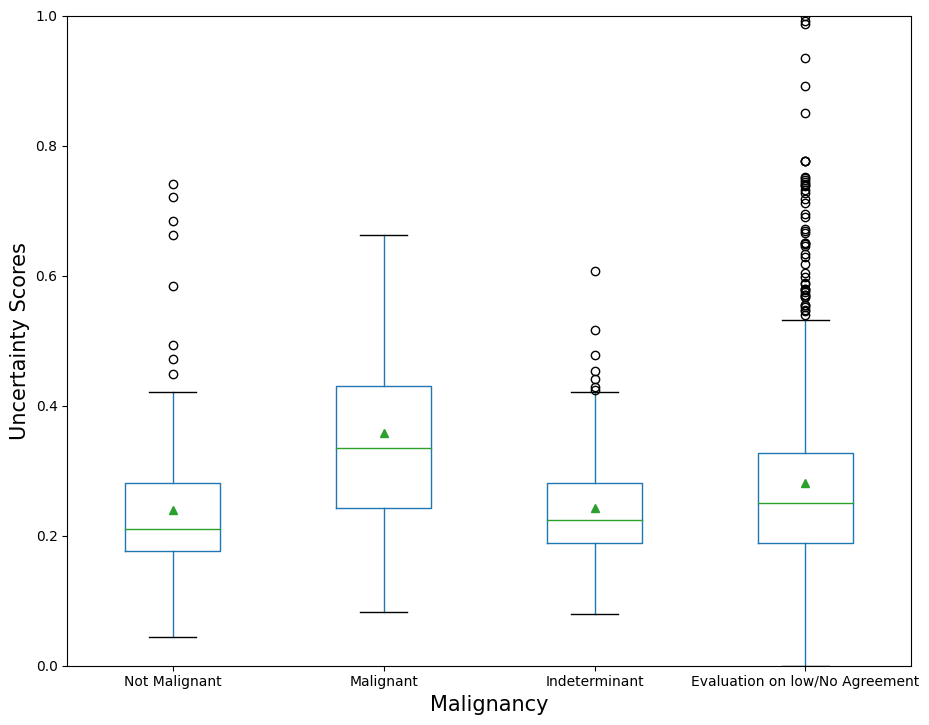

In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Spiculation',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Malignancy", fontdict={'fontsize':15})
plt.xticks([1, 2, 3,4], ['Not Malignant', 'Malignant','Indeterminant', 'Evaluation on low/No Agreement'])
plt.show()

In [ ]:
m1 = df.groupby(['Spiculation'])['Score'].mean().values
print(m1)

[0.23911202 0.35794545 0.24182038 0.28105943]


In [ ]:
m1 = df.groupby(['Spiculation'])['Score'].median().values
print(m1)

[0.20977499 0.3348138  0.22485847 0.24997555]


([<matplotlib.axis.XTick at 0x7f6f14d12790>,
 [Text(1, 0, 'Not Malignant\nAll Radiologists Agree'),
  Text(2, 0, 'Not Malignant\nHigh Radiologist Agreement'),
  Text(3, 0, 'Malignant\nAll Radiologists Agree'),
  Text(4, 0, 'Malignant\nHigh Radiologist Agreement'),
  Text(5, 0, 'Indeterminant\nAll Radiologists Agree'),
  Text(6, 0, 'Indeterminant\nHigh Radiologist Agreement'),
  Text(7, 0, 'Low Radiologist Agreement'),
  Text(8, 0, 'No Radiologist Agreement')])

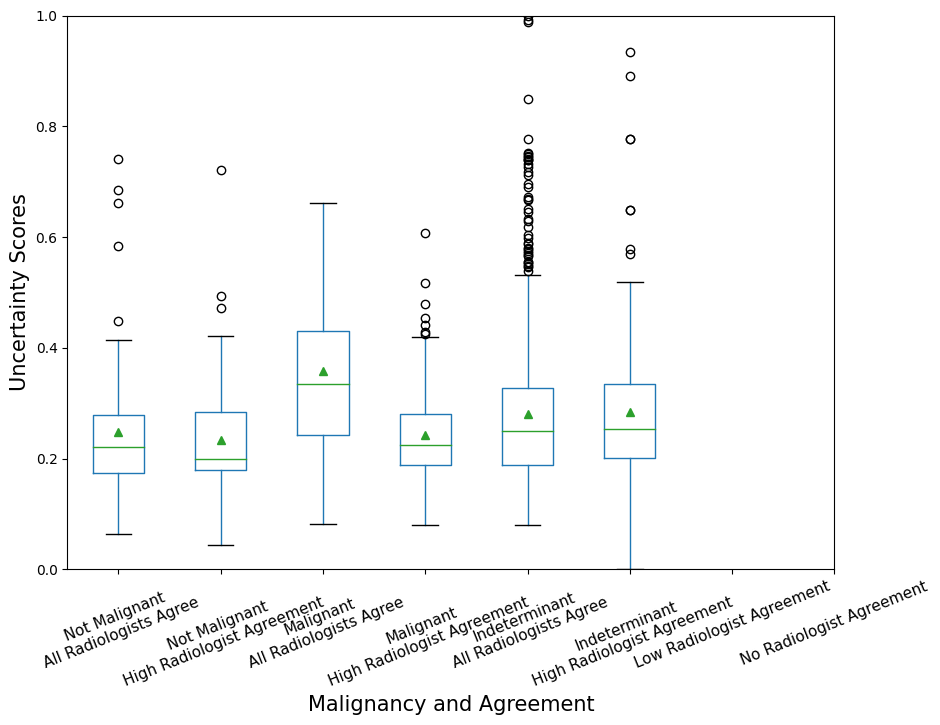

In [ ]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))
newlegend1 = ['Not Malignant', 'Malignant','Indeterminant', 'Evaluation on low/No Agreement']
axes = df.boxplot(by=['Spiculation','Agreement'], column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores",fontdict={'fontsize':15})
plt.xlabel("Malignancy and Agreement",fontdict={'fontsize':15})
plt.xticks([1, 2, 3, 4,5,6,7,8], ["Not Malignant\nAll Radiologists Agree", "Not Malignant\nHigh Radiologist Agreement", "Malignant\nAll Radiologists Agree", "Malignant\nHigh Radiologist Agreement", "Indeterminant\nAll Radiologists Agree", "Indeterminant\nHigh Radiologist Agreement", "Low Radiologist Agreement", "No Radiologist Agreement"], rotation=22, fontsize=11)
#plt.xticks([1, 2, 3], ['Not Spiculated', 'Spiculated', 'Unknown'])

In [ ]:
m1 = df.groupby(['Spiculation','Agreement'])['Score'].describe()
print(m1)

                                        count      mean       std       min  \
Spiculation Agreement                                                         
0           All Radiologists Agree       68.0  0.248137  0.132346  0.063455   
            High Radiologist Agreement   94.0  0.232583  0.098510  0.043475   
1           High Radiologist Agreement   57.0  0.357945  0.140280  0.082275   
2           High Radiologist Agreement  208.0  0.241820  0.086148  0.079722   
3           Low Radiologist Agreement   756.0  0.280365  0.138884  0.080780   
            No Radiologist Agreement    149.0  0.284583  0.147642  0.000000   

                                             25%       50%       75%       max  
Spiculation Agreement                                                           
0           All Radiologists Agree      0.174039  0.221232  0.279466  0.740829  
            High Radiologist Agreement  0.179911  0.199927  0.283684  0.720818  
1           High Radiologist Agreement  0.2

In [ ]:
m1 = df.groupby(['Spiculation','Agreement'])['Score'].median().values
print(m1)

[0.22123185 0.19992674 0.3348138  0.22485847 0.2490682  0.25313907]
